# 🛡️ Regularization Techniques for Deep Learning

**Contents**
1. Introduction: The Overfitting Problem
2. L1 and L2 Regularization (Weight Decay)
3. Dropout
4. Batch Normalization
5. Early Stopping
6. Data Augmentation (Brief Overview)
7. Practical Comparison: Training with PyTorch

## Prerequisites

We will use:
- `numpy` for calculations.
- `matplotlib` for plotting.
- `torch` for practical deep learning examples.
- `sklearn` for datasets.

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.datasets import make_moons
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

np.random.seed(42)
torch.manual_seed(42)
%matplotlib inline

## 1) Introduction: The Overfitting Problem

**Overfitting** occurs when a model learns the training data *too well*, including its noise and random fluctuations. The model essentially memorizes the training set instead of learning the underlying patterns.

**Signs of Overfitting:**
- Training loss continues to decrease.
- Validation/test loss starts to increase (or plateaus while training loss decreases).
- Large gap between training and validation accuracy.

**Why Does It Happen?**
- **Model Complexity:** The model has too many parameters relative to the amount of training data.
- **Training Duration:** Training for too many epochs.
- **Insufficient Data:** Not enough diverse examples for the model to generalize.

**Regularization** is a collection of techniques designed to prevent overfitting by constraining or adding noise to the model during training, forcing it to learn more robust and generalizable features.

## 2) L1 and L2 Regularization (Weight Decay)

These are the classical regularization techniques that add a penalty term to the loss function based on the magnitude of the model's weights.

### 🔹 L2 Regularization (Weight Decay)

**Intuition:** Penalize large weights. By keeping weights small, the model becomes smoother and less likely to fit noise.

The modified loss function becomes:
$$
\mathcal{L}_{\text{total}} = \mathcal{L}_{\text{original}} + \frac{\lambda}{2} \sum_{i} w_i^2
$$

- $\lambda$ (lambda) is the **regularization strength** hyperparameter.
- The penalty is the sum of squared weights (L2 norm).

**Effect on Gradient Descent:**
When we take the gradient of this loss, the weight update becomes:
$$
w = w - \eta (\nabla_w \mathcal{L}_{\text{original}} + \lambda w)
$$
$$
w = (1 - \eta \lambda) w - \eta \nabla_w \mathcal{L}_{\text{original}}
$$

Notice the $(1 - \eta \lambda)$ term: at each step, weights are **decayed** by a small factor before the gradient update. This is why L2 regularization is also called **weight decay**.

### 🔹 L1 Regularization

**Intuition:** Also penalizes large weights, but uses the absolute value instead of the square.

$$
\mathcal{L}_{\text{total}} = \mathcal{L}_{\text{original}} + \lambda \sum_{i} |w_i|
$$

**Key Difference:** L1 regularization encourages **sparsity** — it tends to drive many weights to exactly zero, effectively performing feature selection. L2 regularization shrinks all weights but rarely makes them exactly zero.

**In Practice:** L2 is far more common in deep learning. In PyTorch, weight decay is typically implemented as an argument to the optimizer (e.g., `weight_decay=1e-4` in `optim.Adam`).

## 3) Dropout

**Dropout** is one of the most powerful and widely used regularization techniques in deep learning.

### 🔸 How It Works

During training, dropout randomly **"drops out"** (sets to zero) a fraction $p$ of neurons in a layer at each training step.

**Intuition:** By randomly disabling neurons, we prevent the network from relying too heavily on any single neuron or co-adapted groups of neurons. This forces the network to learn redundant representations, making it more robust.

**Analogy:** Imagine training a team where random members are absent at each practice. The team must learn to function without depending on any single player.

### 🔸 Training vs. Inference

- **During Training:** Neurons are dropped with probability $p$ (e.g., $p=0.5$ means 50% of neurons are randomly set to zero). The remaining neurons' outputs are scaled by $\frac{1}{1-p}$ to maintain the expected output magnitude.
  
- **During Inference (Testing):** **All neurons are active**. No dropout is applied. This is crucial — we want to use the full network for predictions.

### 🔸 Implementation in PyTorch

```python
class NetWithDropout(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(100, 50)
        self.dropout = nn.Dropout(p=0.5)  # Drop 50% of neurons
        self.fc2 = nn.Linear(50, 10)
    
    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = self.dropout(x)  # Apply dropout
        x = self.fc2(x)
        return x
```

PyTorch automatically handles the train/test behavior when you call `model.train()` and `model.eval()`.

**Typical Values:** $p = 0.2$ to $0.5$ for hidden layers. Higher dropout rates (e.g., 0.5) are common for fully connected layers, while lower rates (e.g., 0.1-0.2) are used for convolutional layers.

## 4) Batch Normalization

**Batch Normalization (BatchNorm)** is a technique that normalizes the inputs to each layer, stabilizing and accelerating training.

### 🔸 The Internal Covariate Shift Problem

As the network trains and weights update, the distribution of inputs to each layer keeps changing. This is called **internal covariate shift**, and it forces each layer to continuously adapt to a moving target, slowing down training.

### 🔸 How Batch Normalization Works

For each mini-batch and each feature/channel, BatchNorm:

1. **Normalizes:** Computes the mean $\mu$ and variance $\sigma^2$ of the batch, then normalizes:
   $$
   \hat{x} = \frac{x - \mu}{\sqrt{\sigma^2 + \epsilon}}
   $$
   where $\epsilon$ is a small constant (e.g., $10^{-5}$) for numerical stability.

2. **Scales and Shifts:** Applies learned parameters $\gamma$ (scale) and $\beta$ (shift):
   $$
   y = \gamma \hat{x} + \beta
   $$
   These parameters allow the network to recover the original representation if needed.

### 🔸 Benefits

1. **Faster Training:** Allows higher learning rates.
2. **Reduces Sensitivity:** Less sensitive to weight initialization.
3. **Regularization Effect:** The noise introduced by using batch statistics acts as a mild regularizer (though this is a side effect, not its primary purpose).

### 🔸 Training vs. Inference

- **During Training:** Uses the mean and variance of the current mini-batch.
- **During Inference:** Uses a **running average** of the mean and variance computed across all training batches (stored during training).

### 🔸 Implementation in PyTorch

```python
class NetWithBatchNorm(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(100, 50)
        self.bn1 = nn.BatchNorm1d(50)  # BatchNorm for 1D (fully connected)
        self.fc2 = nn.Linear(50, 10)
    
    def forward(self, x):
        x = self.fc1(x)
        x = self.bn1(x)  # Apply BatchNorm before or after activation
        x = torch.relu(x)
        x = self.fc2(x)
        return x
```

**Note:** There's debate about whether to apply BatchNorm before or after the activation function. Both are used in practice, though after the linear layer and before the activation is more common.

## 5) Early Stopping

**Early stopping** is a simple yet effective regularization technique.

### 🔸 How It Works

**Idea:** Stop training when the validation loss stops improving, even if the training loss is still decreasing.

**Algorithm:**
1. Monitor the validation loss at the end of each epoch.
2. Keep track of the best validation loss seen so far.
3. If the validation loss doesn't improve for a certain number of epochs (**patience**, e.g., 10-20 epochs), stop training.
4. Restore the model weights from the epoch with the best validation loss.

### 🔸 Why It Works

As training progresses, the model fits the training data better and better. Initially, this improves generalization (validation performance improves). But eventually, the model starts to overfit, and validation performance degrades. Early stopping catches this inflection point.

### 🔸 Implementation Pattern

```python
best_val_loss = float('inf')
patience = 10
patience_counter = 0
best_model_state = None

for epoch in range(max_epochs):
    train_loss = train_one_epoch(model, train_loader)
    val_loss = validate(model, val_loader)
    
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        patience_counter = 0
        best_model_state = model.state_dict().copy()  # Save best model
    else:
        patience_counter += 1
    
    if patience_counter >= patience:
        print(f"Early stopping at epoch {epoch}")
        model.load_state_dict(best_model_state)  # Restore best model
        break
```

Early stopping is often used in combination with other regularization techniques.

## 6) Data Augmentation (Brief Overview)

**Data augmentation** artificially increases the size and diversity of the training set by applying random transformations to the data.

### 🔸 Common Augmentations (for Images)

- **Geometric:** Rotation, flipping, cropping, scaling, translation.
- **Color:** Brightness, contrast, saturation adjustments.
- **Noise:** Adding Gaussian noise, blur.

### 🔸 Why It Works

By showing the model slightly different versions of the same data, we force it to learn features that are invariant to these transformations. This improves generalization because the model sees more diverse examples.

**Example in PyTorch (using `torchvision`):**
```python
from torchvision import transforms

transform = transforms.Compose([
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomRotation(15),
    transforms.ColorJitter(brightness=0.2, contrast=0.2),
    transforms.ToTensor(),
])
```

Data augmentation is applied **only during training**, not during validation or testing.

## 7) Practical Comparison: Training with PyTorch

Let's train a neural network on a dataset with **intentional overfitting** conditions (small dataset, complex model), and compare:
1. No regularization (baseline)
2. L2 regularization (weight decay)
3. Dropout
4. Batch Normalization
5. Combination of techniques

In [7]:
# Generate a small, noisy dataset to encourage overfitting
X, y = make_moons(n_samples=500, noise=0.25, random_state=42)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Standardize
scaler = StandardScaler().fit(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

# Convert to PyTorch tensors
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
X_train_t = torch.tensor(X_train, dtype=torch.float32).to(device)
y_train_t = torch.tensor(y_train, dtype=torch.long).to(device)
X_test_t = torch.tensor(X_test, dtype=torch.float32).to(device)
y_test_t = torch.tensor(y_test, dtype=torch.long).to(device)

print(f"Training samples: {len(X_train)}, Test samples: {len(X_test)}")

Training samples: 350, Test samples: 150


In [4]:
# Define model architectures

# 1. Baseline: No regularization
class BaselineNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(2, 128),
            nn.ReLU(),
            nn.Linear(128, 128),
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, 2)
        )
    def forward(self, x):
        return self.net(x)

# 2. With Dropout
class DropoutNet(nn.Module):
    def __init__(self, p=0.3):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(2, 128),
            nn.ReLU(),
            nn.Dropout(p),
            nn.Linear(128, 128),
            nn.ReLU(),
            nn.Dropout(p),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Dropout(p),
            nn.Linear(64, 2)
        )
    def forward(self, x):
        return self.net(x)

# 3. With Batch Normalization
class BatchNormNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(2, 128)
        self.bn1 = nn.BatchNorm1d(128)
        self.fc2 = nn.Linear(128, 128)
        self.bn2 = nn.BatchNorm1d(128)
        self.fc3 = nn.Linear(128, 64)
        self.bn3 = nn.BatchNorm1d(64)
        self.fc4 = nn.Linear(64, 2)

    def forward(self, x):
        x = torch.relu(self.bn1(self.fc1(x)))
        x = torch.relu(self.bn2(self.fc2(x)))
        x = torch.relu(self.bn3(self.fc3(x)))
        return self.fc4(x)

# 4. Combined: Dropout + BatchNorm + L2
class CombinedNet(nn.Module):
    def __init__(self, p=0.2):
        super().__init__()
        self.fc1 = nn.Linear(2, 128)
        self.bn1 = nn.BatchNorm1d(128)
        self.dropout1 = nn.Dropout(p)
        self.fc2 = nn.Linear(128, 128)
        self.bn2 = nn.BatchNorm1d(128)
        self.dropout2 = nn.Dropout(p)
        self.fc3 = nn.Linear(128, 64)
        self.bn3 = nn.BatchNorm1d(64)
        self.dropout3 = nn.Dropout(p)
        self.fc4 = nn.Linear(64, 2)

    def forward(self, x):
        x = self.dropout1(torch.relu(self.bn1(self.fc1(x))))
        x = self.dropout2(torch.relu(self.bn2(self.fc2(x))))
        x = self.dropout3(torch.relu(self.bn3(self.fc3(x))))
        return self.fc4(x)

In [8]:
# Training function
def train_and_evaluate(model, model_name, weight_decay=0.0, epochs=500):
    optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=weight_decay)
    criterion = nn.CrossEntropyLoss()

    train_losses = []
    test_losses = []
    train_accs = []
    test_accs = []

    for epoch in range(epochs):
        # Training
        model.train()
        optimizer.zero_grad()
        outputs = model(X_train_t)
        loss = criterion(outputs, y_train_t)
        loss.backward()
        optimizer.step()

        # Evaluate
        model.eval()
        with torch.no_grad():
            # Training metrics
            train_outputs = model(X_train_t)
            train_loss = criterion(train_outputs, y_train_t).item()
            train_acc = (train_outputs.argmax(dim=1) == y_train_t).float().mean().item()

            # Test metrics
            test_outputs = model(X_test_t)
            test_loss = criterion(test_outputs, y_test_t).item()
            test_acc = (test_outputs.argmax(dim=1) == y_test_t).float().mean().item()

        train_losses.append(train_loss)
        test_losses.append(test_loss)
        train_accs.append(train_acc)
        test_accs.append(test_acc)

    print(f"{model_name:20s} - Train Acc: {train_accs[-1]:.4f}, Test Acc: {test_accs[-1]:.4f}, "
          f"Gap: {train_accs[-1] - test_accs[-1]:.4f}")

    return train_losses, test_losses, train_accs, test_accs

# Train all models
results = {}

torch.manual_seed(42)
model1 = BaselineNet().to(device)
results['Baseline'] = train_and_evaluate(model1, 'Baseline')

torch.manual_seed(42)
model2 = BaselineNet().to(device)
results['L2 (weight_decay)'] = train_and_evaluate(model2, 'L2 (weight_decay)', weight_decay=0.01)

torch.manual_seed(42)
model3 = DropoutNet(p=0.3).to(device)
results['Dropout'] = train_and_evaluate(model3, 'Dropout')

torch.manual_seed(42)
model4 = BatchNormNet().to(device)
results['BatchNorm'] = train_and_evaluate(model4, 'BatchNorm')

torch.manual_seed(42)
model5 = CombinedNet(p=0.2).to(device)
results['Combined'] = train_and_evaluate(model5, 'Combined', weight_decay=0.005)

Baseline             - Train Acc: 0.9886, Test Acc: 0.9067, Gap: 0.0819
L2 (weight_decay)    - Train Acc: 0.9571, Test Acc: 0.9600, Gap: -0.0029
Dropout              - Train Acc: 0.9629, Test Acc: 0.9333, Gap: 0.0295
BatchNorm            - Train Acc: 0.9971, Test Acc: 0.9533, Gap: 0.0438
Combined             - Train Acc: 0.9657, Test Acc: 0.9400, Gap: 0.0257


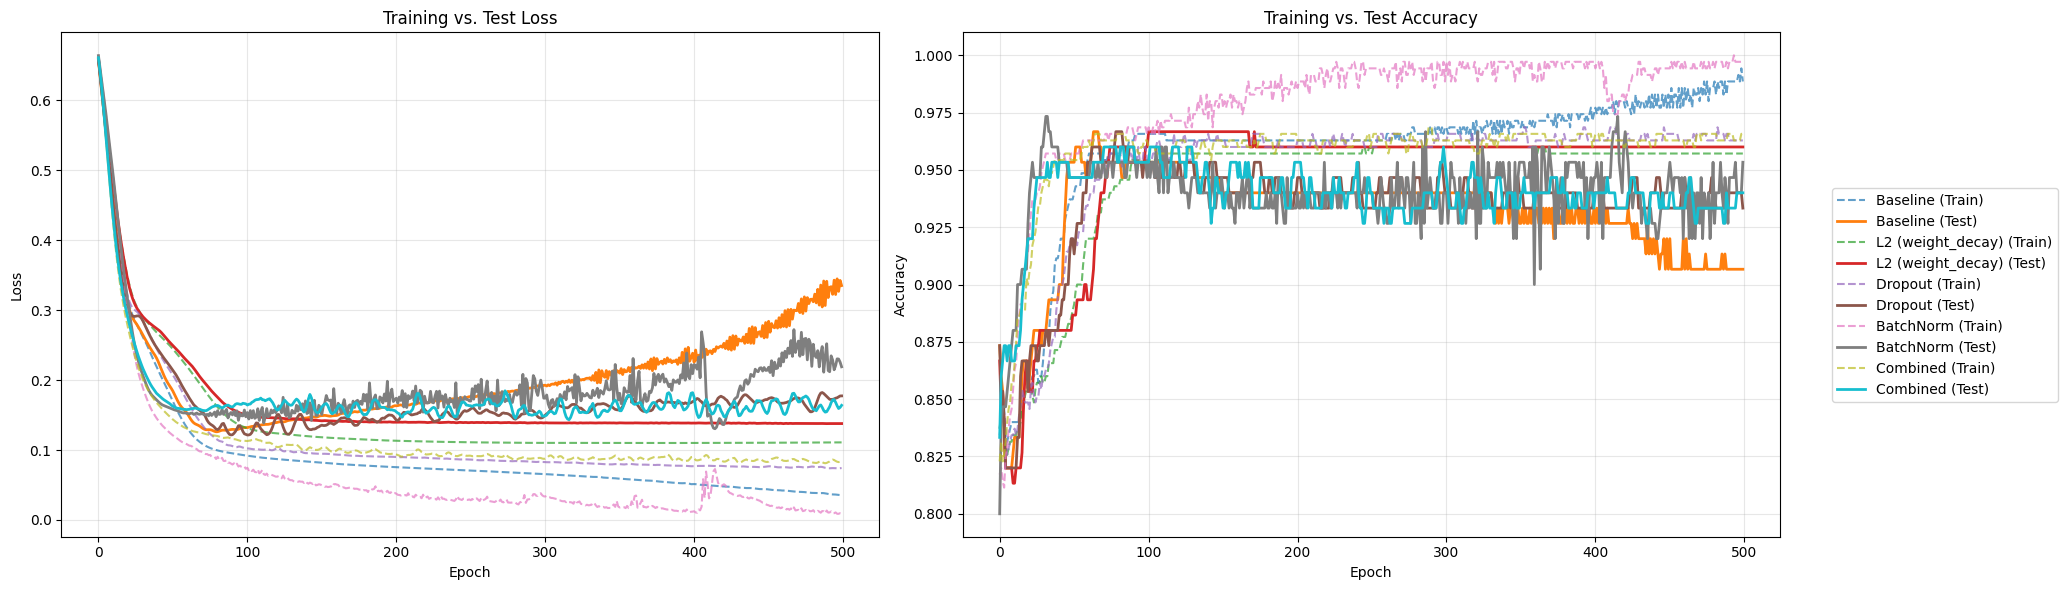

In [10]:
# Plot results
fig, axes = plt.subplots(1, 2, figsize=(18, 6)) # Increase figure size

# Loss curves
for name, (train_loss, test_loss, _, _) in results.items():
    axes[0].plot(train_loss, label=f'{name} (Train)', linestyle='--', alpha=0.7)
    axes[0].plot(test_loss, label=f'{name} (Test)', linewidth=2)

axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Loss')
axes[0].set_title('Training vs. Test Loss')
axes[0].grid(True, alpha=0.3)

# Accuracy curves
for name, (_, _, train_acc, test_acc) in results.items():
    axes[1].plot(train_acc, label=f'{name} (Train)', linestyle='--', alpha=0.7)
    axes[1].plot(test_acc, label=f'{name} (Test)', linewidth=2)

axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Accuracy')
axes[1].set_title('Training vs. Test Accuracy')
# axes[1].legend(bbox_to_anchor=(1.05, 1), loc='upper left') # Remove legend from the second plot
axes[1].grid(True, alpha=0.3)

# Add a single legend for both plots
handles, labels = axes[0].get_legend_handles_labels()
fig.legend(handles, labels, loc='center right', bbox_to_anchor=(1.15, 0.5)) # Position the legend

plt.tight_layout(rect=[0, 0, 1, 1]) # Adjust layout to make space for legend
plt.show()

### Key Observations from Practical Comparison

Based on the training results and plots:

- **Baseline (No Regularization):** Exhibits significant overfitting. The training accuracy is much higher than the test accuracy, and the test loss diverges.
- **L2 Regularization (Weight Decay):** Effectively reduces the generalization gap and achieves higher test accuracy (0.9600) than the baseline, indicating better generalization.
- **Dropout:** Improves test accuracy (0.9333) and reduces overfitting compared to the baseline.
- **Batch Normalization:** Leads to faster and more stable training and improves test accuracy (0.9533).
- **Combined:** Using a combination of techniques also helps in reducing overfitting and improving generalization (Test Acc: 0.9400).

In this specific experiment, L2 regularization resulted in the highest test accuracy, demonstrating its effectiveness in preventing overfitting on this dataset and model architecture.